# Homework nr. 3 - features transformation & selection (deadline 22/11/2018)

In short, the main task is to play with transformations and feature selection methods in order to obtain the best results for linear regression model predicting house sale prices.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (hw3_data.csv, hw3_data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
  2. Split the dataset into train & test part exactly as we did in the tutorial.
  3. Transform the features properly (don't forget the target variable).
  4. Try to find the best subset of features.
  5. Compare your results with the [Kaggle leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard). You should be able to reach approximately the top 20% there.
  
Give comments on each step of your solution, with short explanations of your choices.

  
**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
cf = pd.read_csv('house-prices-advanced-regression-techniques-publicleaderboard.csv')
print("Value for 1% in leaderboard: ",cf['Score'].quantile(0.01))
print("Value for 2% in leaderboard: ",cf['Score'].quantile(0.02))
print("Value for 3% in leaderboard: ",cf['Score'].quantile(0.03))
print("Value for 5% in leaderboard: ",cf['Score'].quantile(0.05))
print("Value for 10% in leaderboard: ",cf['Score'].quantile(0.1))
print("Value for 20% in leaderboard: ",cf['Score'].quantile(0.2))
print("Value for X30% in leaderboard: ",cf['Score'].quantile(0.3))


Value for 1% in leaderboard:  0.10968
Value for 2% in leaderboard:  0.1100182
Value for 3% in leaderboard:  0.11358000000000001
Value for 5% in leaderboard:  0.11482
Value for 10% in leaderboard:  0.11635
Value for 20% in leaderboard:  0.12140999999999999
Value for X30% in leaderboard:  0.12719


In [3]:
# Linear regression with RMSLE does on train and validation data.
def linreg(train, test, plot = False, train_error = True, exp=True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = test.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = test.SalePrice
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))
    
    # If model predict negative value -> set to 0, not optimal but no error :)
    predict_train = clf.predict(X)
    predict_train[predict_train<0] = 0
    predict_test = clf.predict(Xv)
    predict_test[predict_test<0] = 0
    
    # Exp use when transform target attribute using logarithm.
    if exp:
        # Print RMSLE
        print('Linear regression root mean squared log test error:',
          np.sqrt(metrics.mean_squared_log_error(np.exp(predict_test),yv)))
    else:
        # Print RMSLE
        print('Linear regression root mean squared log test error:',
          np.sqrt(metrics.mean_squared_log_error(predict_test,yv)))
    if exp:
        if train_error:
            print('Linear regression root mean squared log train error:', 
              np.sqrt(metrics.mean_squared_error(predict_train, y)))
    else:
        if train_error:
            print('Linear regression root mean squared log train error:', 
              np.sqrt(metrics.mean_squared_log_error(predict_train, y)))
    
    

In [4]:
df = pd.read_csv('hw3_data.csv')

In [5]:
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = \
df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

# Fill all NaN with 0
df.loc[:,df.select_dtypes(include=['float64']).columns] = \
df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

# Convert categorical variables to indicators and create new data
df = pd.get_dummies(df)

In [6]:
# Union all numbers datatype
df[df.select_dtypes(['float16', 'float64', 'int64']).columns] = \
df[df.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

In [7]:
# Remove constant features
df = df[df.columns[df.min() != df.max()]]

In [8]:
# I calculate the total area of the first and second floors and the basement.
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
# Count sqrt from area features.
for column in df.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])

In [9]:
# Split data to train and test
train, test = model_selection.train_test_split(df, test_size=0.25, random_state=179424691)
train = train.copy()
test = test.copy()
print('Train: ', len(train), '; Validation: ', len(test))

Train:  1095 ; Validation:  365


In [10]:
# Check the results without normalization of target variable.
linreg(train, test, exp=False)

Linear regression root mean squared log test error: 0.14745715248501307
Linear regression root mean squared log train error: 0.10309051490351345


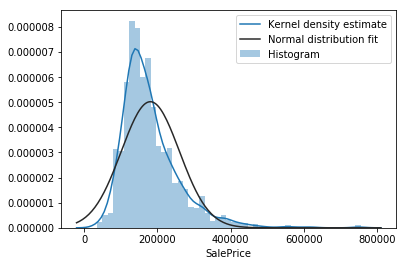

In [11]:
# Distribution of the target varaible
sns.distplot(df.SalePrice, 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )

plt.legend()
# It can be seen in the graph that the distribution of the target change is not normal, 
# and for the linear regression should be the target variable normalized.

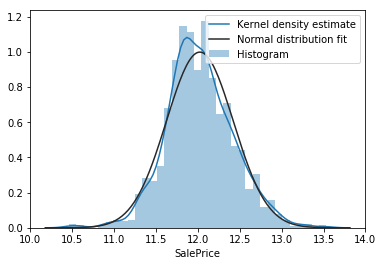

In [12]:
sns.distplot(np.log(df.SalePrice), 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )
plt.legend()

# Fit target variable to normal distribution using log.
train.SalePrice = np.log(train.SalePrice)

In [13]:
# Check the results
linreg(train, test)

Linear regression root mean squared log test error: 0.11543821652710677
Linear regression root mean squared log train error: 0.08788811646892399


`-> We can see that linear regression is quite good after normalization of the target variable.
It is easy to place linear regression data when the target variable has a normal distribution than if it does not have it.`

`-> When I lok on leader bord this normalization is good to hit the first 20% of leaderbord.`

In [14]:
# ID is the first feature to delete. No information.
columns_to_remove = ['Id']
# Find features with low variance - we assume that they cannot help to infer the observable
# this makes sense especially for indicators
columns_to_remove = list(set(list(train.columns[train.var() < 0.0001]) + columns_to_remove)) 

In [15]:
train = train.drop(columns_to_remove, axis=1, errors = 'ignore')
test = test.drop(columns_to_remove, axis=1, errors = 'ignore')

In [16]:
# Check the results
linreg(train, test)

Linear regression root mean squared log test error: 0.11532958221289899
Linear regression root mean squared log train error: 0.08796840043503182


In [17]:
# Correlation matrix Pearson
corrP = train.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
# I try to drop some columns using low correlation but this is not positive effect in score, 
# So I remove only when correlation is lower than 0.001.
# Pearson top 10 with target
corrP_cols = corrP.SalePrice.abs().nlargest(10).index
display(corrP.SalePrice.loc[corrP_cols])
# One can remove those with correlation smaller than some treshold.
additional_columns = list(corrP.SalePrice[corrP.SalePrice.abs() < 0.001].index)
print(additional_columns)
# extend columns_to_remove and remove
columns_to_remove = list(set(columns_to_remove + additional_columns))
train = train.drop(columns_to_remove, axis=1, errors = 'ignore')
test = test.drop(columns_to_remove, axis=1, errors = 'ignore')

SalePrice        1.000000
OverallQual      0.815952
SqrtTotalSF      0.802140
TotalSF          0.766802
SqrtGrLivArea    0.720137
GrLivArea        0.697059
GarageCars       0.672168
GarageArea       0.636227
TotalBsmtSF      0.605597
Sqrt1stFlrSF     0.605439
Name: SalePrice, dtype: float64

[]


In [18]:
# Check the results
linreg(train, test)

Linear regression root mean squared log test error: 0.11532958221289899
Linear regression root mean squared log train error: 0.08796840043503182


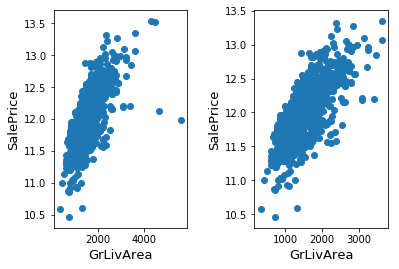

In [19]:
# Vizualization of one feature with target variable.
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5)
ax1.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax1.set_ylabel('SalePrice', fontsize=13)
ax1.set_xlabel('GrLivArea', fontsize=13)

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
ax2.scatter(train['GrLivArea'], train['SalePrice'])
ax2.set_ylabel('SalePrice', fontsize=13)
ax2.set_xlabel('GrLivArea', fontsize=13)
plt.show()


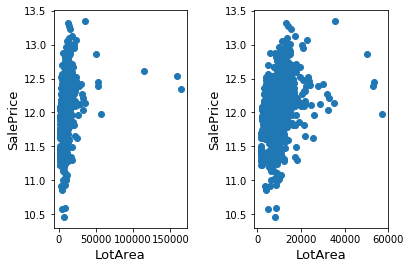

In [20]:
# Vizualization of one feature with target variable.
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5)
ax1.scatter(x = train['LotArea'], y = train['SalePrice'])
ax1.set_ylabel('SalePrice', fontsize=13)
ax1.set_xlabel('LotArea', fontsize=13)

#Deleting outliers
train = train.drop(train[(train['LotArea']>100000)].index)

#Check the graphic again
ax2.scatter(train['LotArea'], train['SalePrice'])
ax2.set_ylabel('SalePrice', fontsize=13)
ax2.set_xlabel('LotArea', fontsize=13)
plt.show()

`-> Drop outliers cant be good always but in this case the LotArea and GrLivArea have some outliers, which can be remove.
When I remove these outliers, the success rate of the model increase. Removing outliers does not have to be a good thing in all datasets and cases, but in this case and these attributes, it has great influence because there are here houses with the large area and low price. This will be hard to predict, but it can worsen model.`


In [21]:
linreg(train, test)

Linear regression root mean squared log test error: 0.11427555798694218
Linear regression root mean squared log train error: 0.0856024090427754


In [22]:
# I check distribution of attributes same as in target variable and 
# It is good use log transform for these attributes to improve model.
train1 = train.copy()
test1 = test.copy()

log_norm = ['SqrtLotArea',  'GrLivArea', 'TotalSF', 'SqrtGrLivArea', 'SqrtTotalSF']

for col in log_norm:
    train1[col] = np.log(train1[col])
    test1[col] = np.log(test1[col])
linreg(train1, test1)

Linear regression root mean squared log test error: 0.11160656488677079
Linear regression root mean squared log train error: 0.08537568999625009


`I tried to use the Lasso method with cross-validation feature selection. It is the possible, to select smaller subset of attributes with good error, but I did not succeed in increasing the value already achieved.`

In [23]:
# The Lasso - L^1 regularized regression to obtain a sparse solution
# Then the non-zero features may be extracted from the result.

# Prepare the data
X = train1.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = train1.SalePrice

used_columns = X.columns

# We use the base estimator Lasso since the L1 norm promotes sparsity of features.
clf = linear_model.Lasso(alpha = 10, max_iter = 10000)

sfm = feature_selection.RFECV(clf, step=1, cv=3, min_features_to_select=190)
sfm.fit(X, y)

# transform result to dataframe
result = pd.DataFrame({'Chosen': sfm.get_support()}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result[result.Chosen == False].head(5))
print('Chosen', result.Chosen.sum(),'from ', result.Chosen.shape[0], 'features.')
linreg(train1[list(columns_to_leave) + ['SalePrice']], test1[list(columns_to_leave) + ['SalePrice']])

,Chosen
MSSubClass,False
LotFrontage,False
Condition2_Norm,False
Condition2_PosA,False
Condition2_PosN,False


Chosen 190 from  311 features.
Linear regression root mean squared log test error: 0.11132388433392244
Linear regression root mean squared log train error: 0.095147752620942


`The best result I achieve when I use PCA on all attributes and select 190 components. Interesting is it the same number which was best in the lasso when selecting attributes. `

In [24]:
from sklearn.decomposition import PCA
# Use data only with target attribute transform.
X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
x = train['SalePrice']
Y = test.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = test['SalePrice']
#create pca mand fit on train data
pca = PCA(n_components=190)

pca.fit(X)

# use the tranformation on both data
train_img = data = pca.transform(X)
test_img = data = pca.transform(Y)

# Test transformation to linear regresion

clf = linear_model.LinearRegression()
clf.fit(train_img, x) 
    
    
# If model predict negative value -> set to 0, not optimal but no error :)
predict_train = clf.predict(train_img)
predict_train[predict_train<0] = 0
predict_test = clf.predict(test_img)
predict_test[predict_test<0] = 0
    
print('Linear regression root mean squared log test error:',
          np.sqrt(metrics.mean_squared_log_error(np.exp(predict_test),y)))

print('Linear regression root mean squared log train error:', 
              np.sqrt(metrics.mean_squared_error(predict_train, x)))




Linear regression root mean squared log test error: 0.10951281483135074
Linear regression root mean squared log train error: 0.09343449115517734
